# Facial Recongnition


In [13]:
#import OpenCV module
import cv2
#import os module for reading training data directories and paths
import os
#import numpy to convert python lists to numpy arrays as 
#it is needed by OpenCV face recognizers
import numpy as np

#matplotlib for display our images
import matplotlib.pyplot as plt
%matplotlib inline 

In [14]:
#there is no label 0 in our training data so subject name for index/label 0 is empty
subjects = ["", "Abbas Zaidi", "Zubair Atha"]

In [15]:
#function to detect face using OpenCV
def detect_face(img):
    #convert the test image to gray image as opencv face detector expects gray images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #load OpenCV face detector, I am using LBP which is fast
    #there is also a more accurate but slow Haar classifier
    face_cascade = cv2.CascadeClassifier('opencv-files/lbpcascade_frontalface.xml')

    #let's detect multiscale (some images may be closer to camera than others) images
    #result is a list of faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5);
    
    #if no faces are detected then return original img
    if (len(faces) == 0):
        return None, None
    
    #under the assumption that there will be only one face,
    #extract the face area
    (x, y, w, h) = faces[0]
    
    #return only the face part of the image
    return gray[y:y+w, x:x+h], faces[0]

In [16]:

def prepare_training_data(data_folder_path):
    
    #------STEP-1--------
    #get the directories (one directory for each subject) in data folder
    dirs = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in dirs:
        
        #our subject directories start with letter 's' so
        #ignore any non-relevant directories if any
        if not dir_name.startswith("s"):
            continue;
            
        #------STEP-2--------
        #extract label number of subject from dir_name
        #format of dir name = slabel
        #, so removing letter 's' from dir_name will give us label
        label = int(dir_name.replace("s", ""))
        
        #build path of directory containin images for current subject subject
        #sample subject_dir_path = "training-data/s1"
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)
        
        #------STEP-3--------
        #go through each image name, read image, 
        #detect face and add face to list of faces
        for image_name in subject_images_names:
            
            #ignore system files like .DS_Store
            if image_name.startswith("."):
                continue;
            
            #build image path
            #sample image path = training-data/s1/1.pgm
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path)
            
            #display an image window to show the image 
            cv2.imshow("Training on image...", image)
            cv2.waitKey(100)
            
            #detect face
            face, rect = detect_face(image)
            
            #------STEP-4--------
            #for the purpose of this tutorial
            #we will ignore faces that are not detected
            if face is not None:
                #add face to list of faces
                faces.append(face)
                #add label for this face
                labels.append(label)
            
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cv2.destroyAllWindows()
    
    return faces, labels

In [9]:

import cv2
import os
cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 1

while True:
    
    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
    cv2.imshow("test", frame)

    k = cv2.waitKey(1)
    if k%256 == 27:
        # ESC pressed
        print("Escape hit, closing...")
        break
    elif k%256 == 32:
        # SPACE pressed
        img_name = "{}.png".format(img_counter)
        cv2.imwrite(img_name, frame)
        print("{} written!".format(img_name))
        img_counter += 1

cam.release()

cv2.destroyAllWindows()


'\nimport cv2\nimport os\ncam = cv2.VideoCapture(0)\n\ncv2.namedWindow("test")\n\nimg_counter = 1\n\nwhile True:\n    \n    ret, frame = cam.read()\n    if not ret:\n        print("failed to grab frame")\n        break\n    cv2.imshow("test", frame)\n\n    k = cv2.waitKey(1)\n    if k%256 == 27:\n        # ESC pressed\n        print("Escape hit, closing...")\n        break\n    elif k%256 == 32:\n        # SPACE pressed\n        img_name = "{}.png".format(img_counter)\n        cv2.imwrite(img_name, frame)\n        print("{} written!".format(img_name))\n        img_counter += 1\n\ncam.release()\n\ncv2.destroyAllWindows()\n'

In [22]:
#let's first prepare our training data
#data will be in two lists of same size
#one list will contain all the faces
#and other list will contain respective labels for each face
print("Preparing data...")
faces, labels = prepare_training_data("training-data")
print("Data prepared")

#print total faces and labels
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Preparing data...
Data prepared
Total faces:  12
Total labels:  12


In [23]:
#create our LBPH face recognizer 
face_recognizer = cv2.face.LBPHFaceRecognizer_create()



In [24]:
#training the model

face_recognizer.train(faces, np.array(labels))


In [25]:
#function to draw rectangle on image 
#according to given (x, y) coordinates and 
#given width and heigh
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
#function to draw text on give image starting from
#passed (x, y) coordinates. 
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

In [27]:
#this function recognizes the person in image passed
#and draws a rectangle around detected face with name of the 
#subject

def predict(test_img):
    #make a copy of the image as we don't want to chang original image
    img = test_img.copy()
    #detect face from the image
    face, rect = detect_face(img)
    
    #predict the image using our face recognizer 
    label= face_recognizer.predict(face)
    label=list(label)
    label=label[0]
    #plt.imshow(face)
    #plt.title(subjects[label])
    #get name of respective label returned by face recognizer
    label_text = subjects[label]
    
    #draw a rectangle around face detected
    draw_rectangle(img, rect)
    #draw name of predicted person
    draw_text(img, label_text, rect[0], rect[1]-5)
    #plt.imshow(img)
    
    return img

In [28]:
# program to capture test image & saving in test directory

# importing OpenCV library
import cv2 as cv
import os
# initialize the camera
# If you have multiple camera connected with
# current device, assign a value in cam_port
# variable according to that

cam = cv.VideoCapture(0)

# reading the input using the camera
result, image = cam.read()
path="F:/COURSES/Computer_vision/Facial_Recongnition/test-data"


# If image will detected without any error,
# show result
if result:

    # showing result, it take frame name and image
    # output
    cv.imshow("Image captured", image)

    # saving image in local storage


    # If keyboard interrupt occurs, destroy image
    # window
    cv.waitKey(0)
    cv.destroyWindow("Image captured")
    cv.imwrite(os.path.join(path, "test1.png"),image)

# If captured image is corrupted, moving to else part
else:
    print("No image detected. Please! try again")


Predicting images...


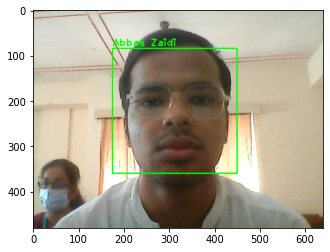

In [29]:
print("Predicting images...")

#load test images
test_img1 = cv2.imread("test-data/test1.png")


#perform a prediction
predicted_img1 = predict(test_img1)


plt.imshow(cv2.cvtColor(predicted_img1, cv2.COLOR_BGR2RGB))


#display both images
cv2.imshow("Predicted Image", predicted_img1)

cv2.waitKey(0)
cv2.destroyAllWindows()